In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_file = "/home/olle/PycharmProjects/LODE/workspace/sequence_data/longitudinal_properties.csv"
data_pd = pd.read_csv(data_file)

In [2]:
data_pd.head(20)

,Unnamed: 0,sequence,study_date_1,total_fluid_1,time_range_1,time_range_before_1,time_range_after_1,insertion_type_1,cur_va_rounded_1,next_va_1,...,next_va_24,intra_retinal_fluid_24,sub_retinal_fluid_24,srhm_24,fibrovascular_ped_24,choroid_24,drusen_24,rpe_24,epiretinal_membrane_24,fibrosis_24
0,2,502_R,2016-04-04,0.000534,NaN,NaN,NaN,NaN,0.10,0.494850,...,0.078451,0.000267,0.001013,0.000821,0.095364,1.753434,0.065789,0.489890,0.001536,0.000401
1,10,1557_L,2014-10-20,0.017480,NaN,NaN,NaN,NaN,1.10,1.096910,...,1.301030,0.000152,0.000571,0.055693,0.210156,2.075865,0.003946,0.252950,0.018018,0.277361
2,11,1557_R,2013-09-20,0.389026,NaN,NaN,NaN,NaN,0.70,0.698970,...,0.698970,0.000693,0.001843,0.019360,0.240204,2.128582,0.008848,0.437410,0.008200,0.067541
3,13,1570_R,2014-02-17,0.002409,NaN,NaN,NaN,NaN,0.70,0.602060,...,0.795880,0.111120,0.001271,0.012301,0.369197,1.981089,0.006128,0.445304,0.008235,0.046260
4,19,3897_R,2014-02-21,0.009870,NaN,NaN,NaN,NaN,0.30,0.102373,...,0.265605,0.002098,0.061646,0.000170,0.099569,0.017839,0.035282,0.489694,0.228036,0.000000
5,20,4206_L,2013-08-13,0.252856,NaN,NaN,NaN,NaN,1.18,0.886057,...,0.886057,0.060799,0.004836,0.048626,0.435461,3.406546,0.000395,0.405971,0.006854,0.015847
6,23,4353_L,2014-02-20,0.002724,NaN,NaN,NaN,NaN,0.20,0.301030,...,NaN,0.000422,0.181441,0.000000,0.110744,1.065789,0.001992,0.501481,0.069733,0.000000
7,26,5091_L,2014-01-20,0.052803,NaN,NaN,NaN,NaN,1.54,1.698970,...,NaN,0.000169,0.037901,0.006163,0.488533,1.700317,0.010257,0.485732,0.048878,0.004116
8,28,5249_L,2014-04-29,0.000433,NaN,NaN,NaN,NaN,0.40,0.397940,...,0.543582,0.000697,0.000124,0.027822,0.067020,2.022039,0.001337,0.365908,0.035246,0.465482
9,29,5249_R,2014-04-29,0.009502,NaN,NaN,NaN,NaN,0.49,0.397940,...,0.795880,0.250686,0.152104,0.128621,0.436536,1.620521,0.000288,0.234709,0.025624,0.558414


In [3]:
data_pd.columns

Index(['Unnamed: 0', 'sequence', 'study_date_1', 'total_fluid_1',
       'time_range_1', 'time_range_before_1', 'time_range_after_1',
       'insertion_type_1', 'cur_va_rounded_1', 'next_va_1',
       'intra_retinal_fluid_1', 'sub_retinal_fluid_1', 'srhm_1',
       'fibrovascular_ped_1', 'choroid_1', 'drusen_1', 'rpe_1',
       'epiretinal_membrane_1', 'fibrosis_1', 'study_date_3', 'total_fluid_3',
       'time_range_3', 'time_range_before_3', 'time_range_after_3',
       'insertion_type_3', 'cur_va_rounded_3', 'next_va_3',
       'intra_retinal_fluid_3', 'sub_retinal_fluid_3', 'srhm_3',
       'fibrovascular_ped_3', 'choroid_3', 'drusen_3', 'rpe_3',
       'epiretinal_membrane_3', 'fibrosis_3', 'study_date_6', 'total_fluid_6',
       'time_range_6', 'time_range_before_6', 'time_range_after_6',
       'insertion_type_6', 'cur_va_rounded_6', 'next_va_6',
       'intra_retinal_fluid_6', 'sub_retinal_fluid_6', 'srhm_6',
       'fibrovascular_ped_6', 'choroid_6', 'drusen_6', 'rpe_6',
     

#### How many sequence are treated?

In [4]:
print(f"number of treated sequences {data_pd.shape[0]}")

number of treated sequences 397


#### Insertion type distribution

Text(0.5, 1.0, 'month 24')

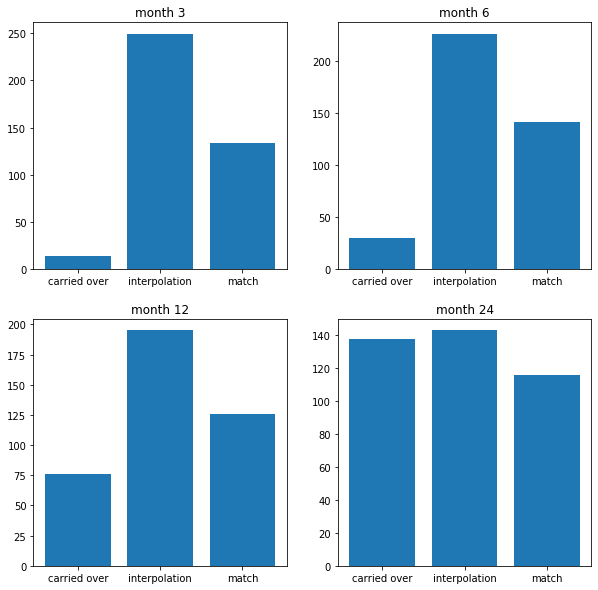

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

month_3 = data_pd.groupby(['insertion_type_3']).size().tolist()
month_6 = data_pd.groupby(['insertion_type_6']).size().tolist()
month_12 = data_pd.groupby(['insertion_type_12']).size().tolist()
month_24 = data_pd.groupby(['insertion_type_24']).size().tolist()

x_labels = ["carried over", "interpolation", "match"]

ax1.bar(x_labels, month_3,align='center')
ax1.set_title("month 3")
ax2.bar(x_labels,month_6,align='center')
ax2.set_title("month 6")
ax3.bar(x_labels,month_12,align='center')
ax3.set_title("month 12")
ax4.bar(x_labels,month_24,align='center')
ax4.set_title("month 24")

### carried over time distribution

Text(0.5, 1.0, 'Time from carry over 6 months')

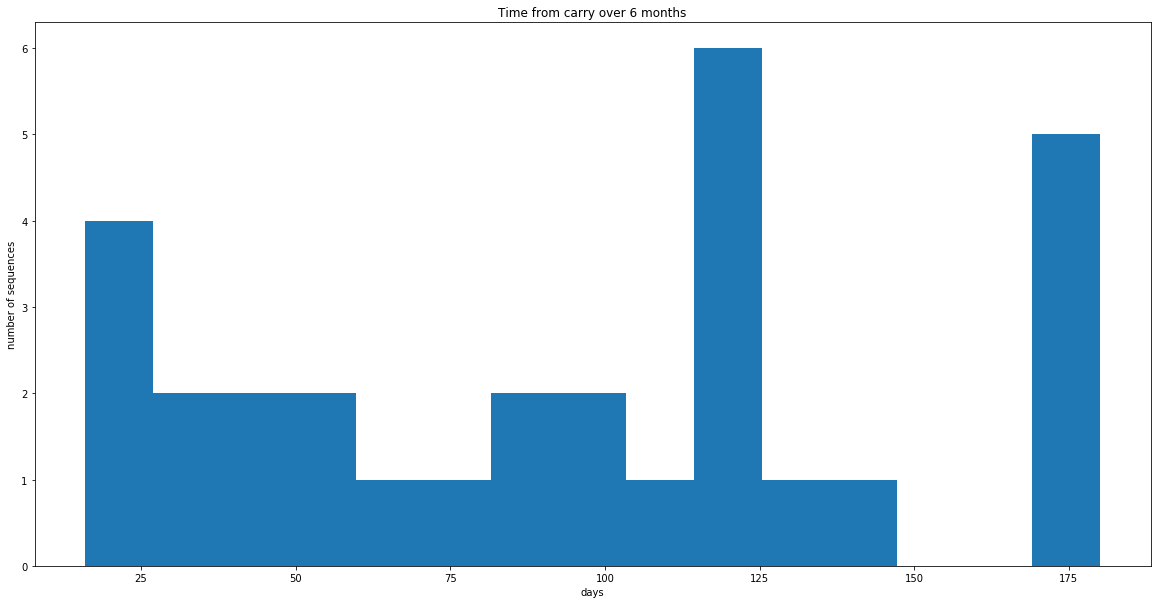

In [6]:
plt.figure(figsize=(20,10))
month_6_carry_over = data_pd.loc[data_pd.insertion_type_6 == "carry_over"]
plt.hist(month_6_carry_over.time_range_6, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 6 months")

Text(0.5, 1.0, 'Time from carry over 12 months')

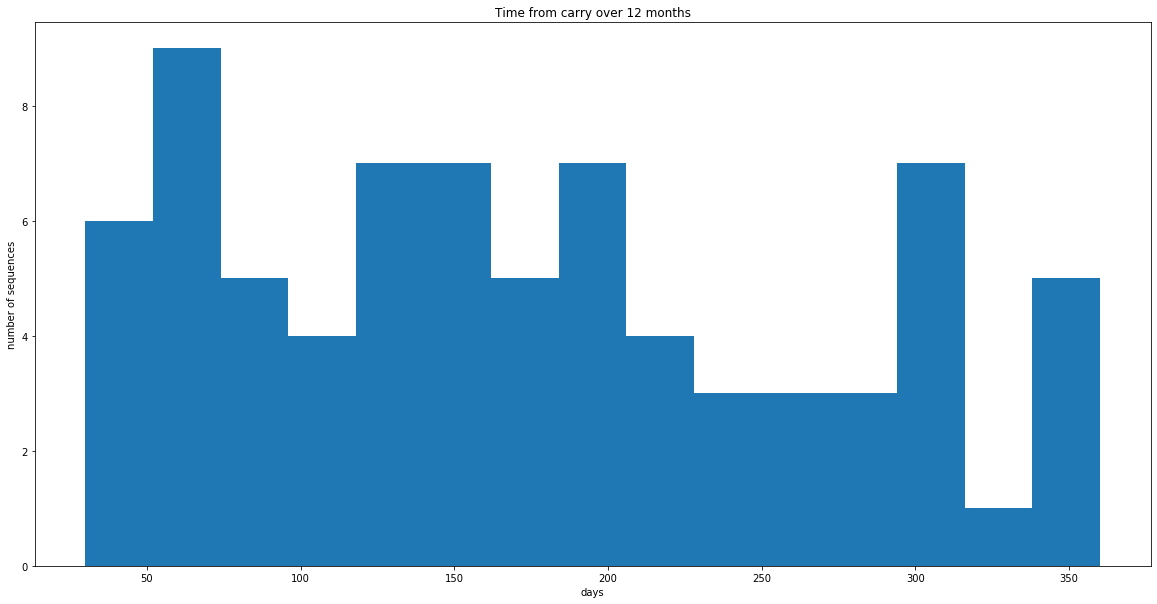

In [7]:
plt.figure(figsize=(20,10))
month_12_carry_over = data_pd.loc[data_pd.insertion_type_12 == "carry_over"]
plt.hist(month_12_carry_over.time_range_12, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 12 months")


### interpolation over time distribution

Text(0.5, 1.0, 'Time from interpolation 6 months')

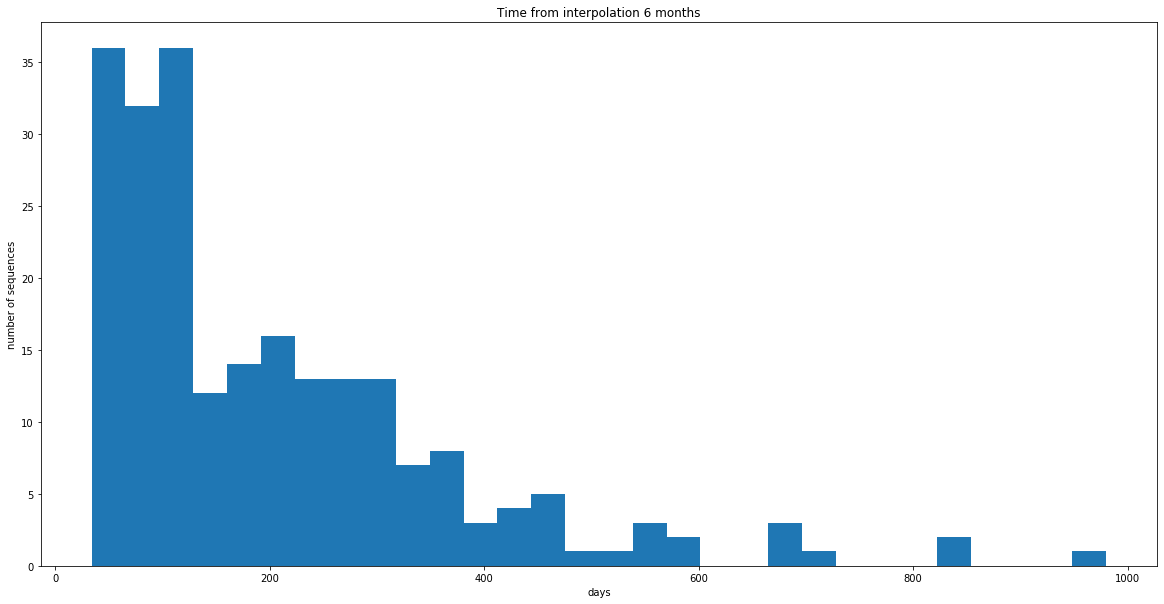

In [8]:
plt.figure(figsize=(20,10))
month_6_interpolation = data_pd.loc[data_pd.insertion_type_6 == "interpolation"]
plt.hist(month_6_interpolation.time_range_6, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 6 months")

Text(0.5, 1.0, 'Time from interpolation 12 months')

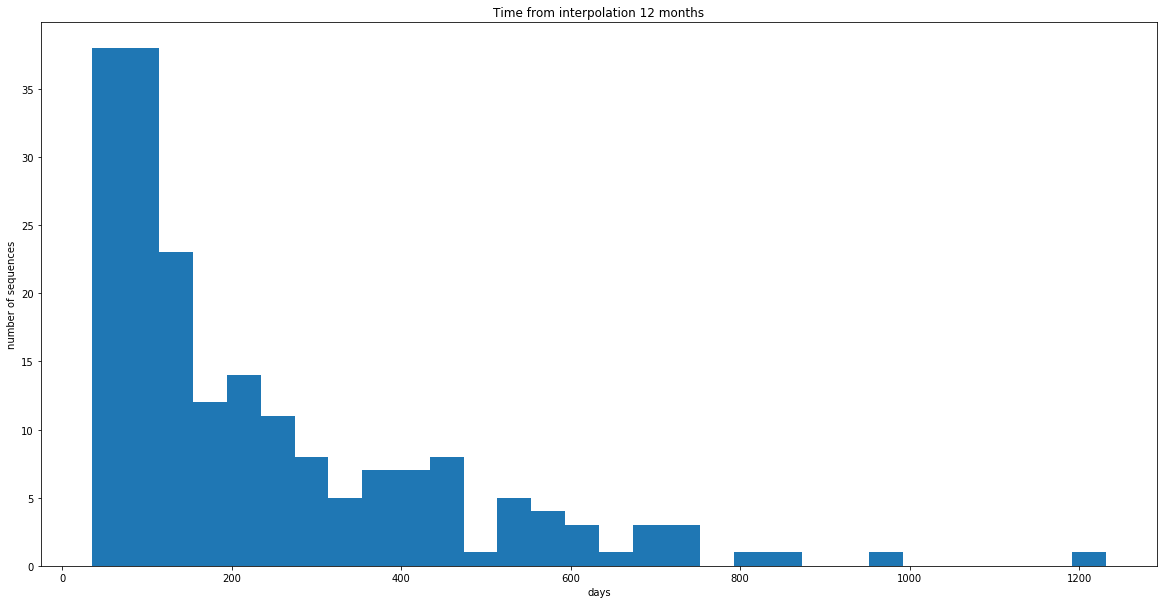

In [9]:
plt.figure(figsize=(20,10))
month_12_interpolation = data_pd.loc[data_pd.insertion_type_12 == "interpolation"]
plt.hist(month_12_interpolation.time_range_12, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 12 months")

#### Time until dry

In [10]:
start_dry = data_pd.total_fluid_1 == 0

print(f"Number of sequences starting as dry: ", sum(start_dry))

# exclude dry start sequences
fluid_pd = data_pd.loc[~start_dry]

print(f"Number of sequences dry after 3 months: ", sum(fluid_pd.total_fluid_3 == 0))
print(f"Number of sequences dry after 6 months: ", sum(fluid_pd.total_fluid_6 == 0))
print(f"Number of sequences dry after 12 months: ", sum(fluid_pd.total_fluid_12 == 0))
print(f"Number of sequences dry after 24 months: ", sum(fluid_pd.total_fluid_24 == 0))



Number of sequences starting as dry:  3
Number of sequences dry after 3 months:  2
Number of sequences dry after 6 months:  1
Number of sequences dry after 12 months:  1
Number of sequences dry after 24 months:  3


#### Filter data based on time series eclusion criterias

In [11]:
##### carry over above 2 months

In [12]:
columns = ["time_range_6", "time_range_before_6", "time_range_after_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12",
          "insertion_type_6", "insertion_type_12"]

filter_base = data_pd[columns]

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 


interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match" 

# interpolation time filters
interp_time_before_6 = filter_base.time_range_before_6 < 60
interp_time_after_6 = filter_base.time_range_after_6 < 60

interp_time_before_12 = filter_base.time_range_before_12 < 60
interp_time_after_12 = filter_base.time_range_after_12 < 60

# carry over time filters
carry_over_time_after_6 = filter_base.time_range_6 < 60
carry_over_time_after_12 = filter_base.time_range_12 < 60

In [13]:
# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))

Number of filtered sequences for 6 months are: 220


In [14]:
# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

Number of filtered sequences for 12 months are: 195


#### Define VA fate groups

In [15]:
#### Worsened v. Imporoved

In [16]:
data_6 = data_pd.loc[filter_6]
data_12 = data_pd.loc[filter_12]

In [17]:
va_delta_6 = data_6.cur_va_rounded_6 - data_6.cur_va_rounded_1 
va_delta_12 = data_12.cur_va_rounded_12 - data_12.cur_va_rounded_1 

data_6["six_month_recovery"] = va_delta_6 <= 0
data_12["twelwe_month_recovery"] = va_delta_12 <= 0

print("six month recovery: ", sum(data_6["six_month_recovery"]))
print("twelwe month recovery: ", sum(data_12["twelwe_month_recovery"]))

six month recovery:  139
twelwe month recovery:  93


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
### Improved from VI to NVI

In [19]:
vi6_1 = data_6.cur_va_rounded_1 >= 0.4 
nvi_6 = data_6.cur_va_rounded_6 < 0.4

vi12_1 = data_12.cur_va_rounded_1 >= 0.4 
nvi_12 = data_12.cur_va_rounded_12 < 0.4 

data_6["six_month_vi_recovery"] = np.logical_and(vi6_1.values, nvi_6.values)
data_12["twelwe_month_vi_recovery"] = np.logical_and(vi12_1.values, nvi_12.values)

print("six month vi recovery: ", sum(data_6["six_month_vi_recovery"]))
print("twelwe month vi recovery: ", sum(data_12["twelwe_month_vi_recovery"]))

six month vi recovery:  18
twelwe month vi recovery:  15


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
### Improved from LB to NLB

In [21]:
lb6_1 = data_6.cur_va_rounded_1 >= 1.0
nlb_6 = data_6.cur_va_rounded_6 < 1.0 

lb12_1 = data_12.cur_va_rounded_1 >= 1.0
nlb_12 = data_12.cur_va_rounded_12 < 1.0 

data_6["six_month_lb_recoverment"] = np.logical_and(lb6_1.values, nlb_6.values)
data_12["twelwe_month_lb_recoverment"] = np.logical_and(lb12_1.values, nlb_12.values)

print("six month lb recoverment: ", sum(data_6["six_month_lb_recoverment"]))
print("twelwe month lb recoverment: ", sum(data_12["twelwe_month_lb_recoverment"]))


six month lb recoverment:  12
twelwe month lb recoverment:  15


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### VA outcome distribution plotting

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
sns.set_theme(style="whitegrid")

In [ ]:


x = df.values #returns a numpy array
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

array([ True,  True,  True, ...,  True,  True,  True])

In [68]:
outlier = data_6_plotting.values != 1.000
outlier

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Text(0, 0.5, 'Normalized feature distribution')

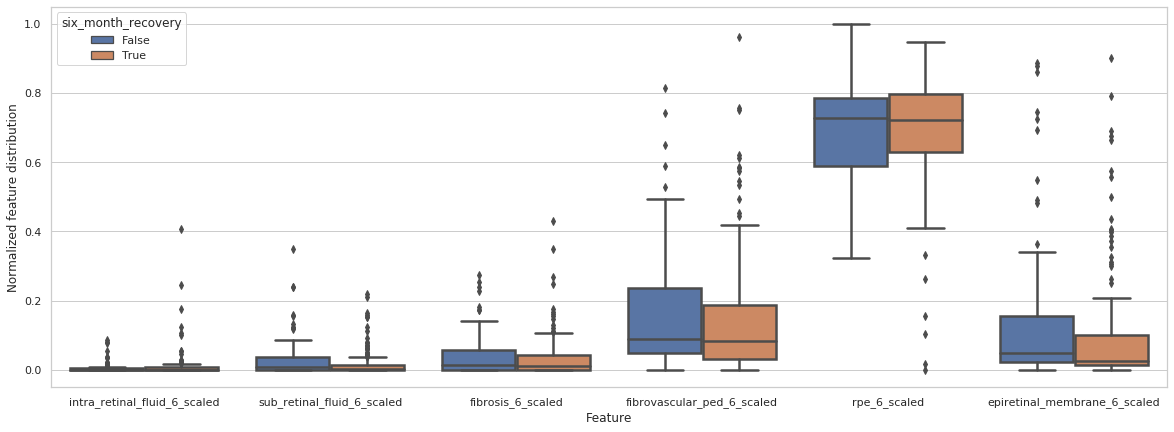

In [75]:
#### six month outcome
value_columns = ["intra_retinal_fluid_6", "sub_retinal_fluid_6", "fibrosis_6", 
          "fibrovascular_ped_6", "rpe_6", "epiretinal_membrane_6"]

for column in value_columns:
    col_values = data_6[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_6[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_6_scaled", 
                        "sub_retinal_fluid_6_scaled", "fibrosis_6_scaled", 
                        "fibrovascular_ped_6_scaled", "rpe_6_scaled", 
                        "epiretinal_membrane_6_scaled"]


data_6_plotting = pd.melt(data_6, id_vars=["six_month_recovery"], value_vars=value_columns_scaled)

data_6_plotting = data_6_plotting.loc[data_6_plotting.value.values != 1.000]

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="six_month_recovery",
                 data=data_6_plotting, linewidth=2.5)

plt.xlabel("Feature")
plt.ylabel("Normalized feature distribution")

/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

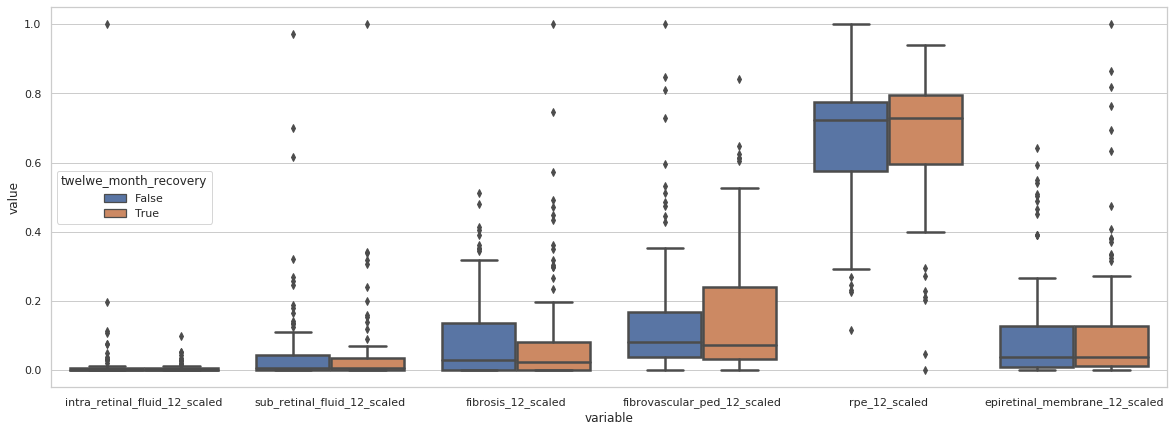

In [48]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_12", "sub_retinal_fluid_12", "fibrosis_12", 
          "fibrovascular_ped_12", "rpe_12", "epiretinal_membrane_12"]

for column in value_columns:
    col_values = data_12[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_12[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_12_scaled", 
                        "sub_retinal_fluid_12_scaled", "fibrosis_12_scaled", 
                        "fibrovascular_ped_12_scaled", "rpe_12_scaled", 
                        "epiretinal_membrane_12_scaled"]

data_12_plotting = pd.melt(data_12, id_vars=["twelwe_month_recovery"], value_vars=value_columns_scaled)

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="twelwe_month_recovery",
                 data=data_12_plotting, linewidth=2.5)

In [28]:
data_6_plotting

,six_month_recovery,variable,value
0,False,intra_retinal_fluid_6,0.002220
1,False,intra_retinal_fluid_6,0.000000
2,True,intra_retinal_fluid_6,0.017884
3,True,intra_retinal_fluid_6,0.010911
4,False,intra_retinal_fluid_6,0.009699
...,...,...,...
1315,True,epiretinal_membrane_6,0.022617
1316,True,epiretinal_membrane_6,0.002523
1317,False,epiretinal_membrane_6,0.010130
1318,True,epiretinal_membrane_6,0.002603
